## Read data

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA

train1 = pd.read_csv('../data/training_1.csv')
train1.head()

,DATETIME,L_T1,L_T2,L_T3,L_T4,L_T5,L_T6,L_T7,F_PU1,S_PU1,...,P_J256,P_J289,P_J415,P_J302,P_J306,P_J307,P_J317,P_J14,P_J422,ATT_FLAG
0,06/01/14 00,0.509730,2.049003,3.191145,2.792634,2.656091,5.316831,1.562321,98.998444,1,...,87.605774,26.495605,84.206619,18.901676,81.983734,18.791777,67.125603,29.387470,28.487471,0
1,06/01/14 01,0.412580,2.009072,3.642565,2.831673,3.126387,5.494855,1.852043,99.095901,1,...,89.448341,26.487326,85.900085,18.849329,82.150589,18.739643,67.178696,29.354256,28.454256,0
2,06/01/14 02,0.320112,1.986093,4.140192,3.256733,3.574601,5.500000,2.246126,98.420959,1,...,91.056114,26.487364,86.582474,19.597170,83.988579,19.496712,72.425293,29.354538,28.454538,0
3,06/01/14 03,0.332879,2.009203,4.673478,3.744497,3.952379,5.500000,3.203573,97.575172,1,...,92.594353,26.575815,88.020546,26.028486,64.670486,25.922703,76.275040,29.449951,28.549952,0
4,06/01/14 04,0.483496,2.089049,5.237937,4.409456,3.504676,5.500000,4.439714,97.351059,1,...,94.473099,26.723457,90.422462,26.209970,64.746620,26.104692,76.703529,29.574265,28.674263,0


## Correlation matrix

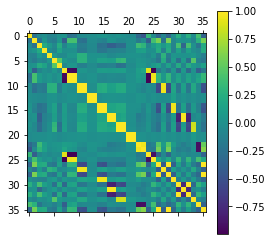

In [81]:
# remove the date and truth label columns
df_corr = train1.copy()
df_corr = df_corr.drop(columns=['ATT_FLAG', 'DATETIME'])

# remove constants, because corr is undefined for constants
constants = [x for x in df_corr if np.std(df_corr[x]) == 0]
df_corr = df_corr.drop(columns=constants)

# plot it all
plt.matshow(df_corr.corr())
plt.colorbar()
plt.savefig('corr_plot')
plt.show()

## Show correlation and cyclic behavior for F_PU1 and P_J280

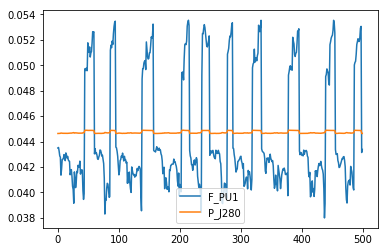

In [82]:
import sklearn
from sklearn.preprocessing import normalize

corrmat_names = list(train1.corr())
sig1 = 7
sig2 = 31

# normalize to show both in one plot
plt.plot(normalize(train1[corrmat_names[sig1]][:500].values.reshape(1, -1)).reshape(-1, 1), label=corrmat_names[sig1])
plt.plot(normalize(train1[corrmat_names[sig2]][:500].values.reshape(1, -1)).reshape(-1, 1), label=corrmat_names[sig2])
plt.legend()
plt.savefig('fpu1_pj280')
plt.show()

## Partial auto-correlation function for F_PU7

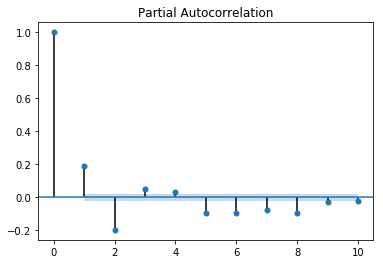

In [83]:
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(train1['F_PU7'], lags=10)
plt.savefig('fpu7_pacf')
plt.show()

## Cyclic behavior - Autocorellation plot for L_T2 

In [ ]:
from pandas.plotting import autocorrelation_plot as ap

ap(train1['L_T2']).plot()
plt.show()


## Simple Predictions using an AR(5) model

In [ ]:
from statsmodels.tsa.arima_model import AR

train2 = pd.read_csv('../data/training_2.csv')

signal = "F_PU1"

# define and fit the AR model
p = 5
model = AR(train1[signal])
model_fit = model.fit(p)

'''
predict the next value in a time series given the history and a list of coefficients.
'''
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

# define the test signal
test = train2[signal]
# obtain AR coefficients
ar_coef = model_fit.params
# keep the first p test signal values  
history = [train2[signal].iloc[x] for x in range(0,p)]

# start predicting!
predictions = list()
for t in range(p,len(test)):
    # next value prediction
    yhat = predict(ar_coef, history)

    # book-keeping
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

# compute residuals and compare to signal mean
res = np.subtract(test[p:], predictions)
res = res - np.mean(res)
print(np.sum(np.abs(res))/len(res))

# plot predictions and true values
plt.plot(train2[signal].iloc[p:])
plt.plot(predictions)
plt.legend(['True Signal Values','Predicted Signal Values'])
plt.show()
